In [1]:
import pandas as pd
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from sklearn import svm

from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten
from keras.optimizers import Adam ,RMSprop
from keras.utils.np_utils import to_categorical

from keras.layers.core import Dense, Activation, Dropout

from keras.models import  Sequential
from keras.layers.core import  Lambda , Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, Convolution2D , MaxPooling2D
from keras.preprocessing import image

%matplotlib inline

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 280841409289209534
]


In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

In [4]:
train = pd.read_csv("../input/train.csv")
test= pd.read_csv("../input/test.csv")

In [5]:
X_train = (train.ix[0:5000,1:].values).astype('float32') # all pixel values
y_train = train.ix[0:5000,0].values.astype('int32') # only labels i.e targets digits
X_test = test.values.astype('float32')

/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


In [6]:
X_train = X_train.reshape(X_train.shape[0], 28, 28)

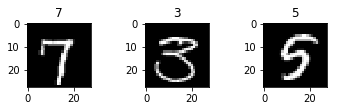

In [7]:
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    plt.title(y_train[i]);

In [8]:
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)

In [9]:
y_train= to_categorical(y_train)
num_classes = y_train.shape[1]
num_classes

10

In [10]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, train_size=0.8, random_state=0)

/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [11]:
mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)

def standardize(x): 
    return (x-mean_px)/std_px

In [12]:
# fix random seed for reproducibility
seed = 43
np.random.seed(seed)

In [13]:
models = {}

In [14]:
def create_simple_model():
    model= Sequential()
    model.add(Lambda(standardize,input_shape=(28,28,1)))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    print("input shape ",model.input_shape)
    print("output shape ",model.output_shape)
    return model
models['simple'] = create_simple_model()

input shape  (None, 28, 28, 1)
output shape  (None, 10)


In [15]:
def create_ddmlp_model():
    model= Sequential()
    model.add(Lambda(standardize,input_shape=(28,28,1)))
    #model.add(Dense(128))#, input_dim=28))
    #model.add(Activation('relu'))
    #model.add(Dropout(0.15))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.15))
    model.add(Flatten())
    model.add(Dense(10))
    model.add(Activation('softmax'))
    print("input shape ",model.input_shape)
    print("output shape ",model.output_shape)
    return model
#models['DDMLP'] = create_ddmlp_model()

input shape  (None, 28, 28, 1)
output shape  (None, 10)


In [16]:
def create_tut_model():
    model= Sequential()
    model.add(Lambda(standardize,input_shape=(28,28,1)))
    model.add(Convolution2D(32, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    print("input shape ",model.input_shape)
    print("output shape ",model.output_shape)
    return model
models['tut'] = create_tut_model()

input shape  (None, 28, 28, 1)
output shape  (None, 10)


In [17]:
for model in models:
    models[model].compile(optimizer=RMSprop(lr=0.001),
         loss='categorical_crossentropy',
         metrics=['accuracy'])

In [18]:
gen = image.ImageDataGenerator()

In [19]:
batches = gen.flow(X_train, y_train, batch_size=64)
val_batches=gen.flow(X_validation, y_validation, batch_size=64)

In [20]:
histories = {}

In [21]:
import tensorflow as tf
#with tf.device('/gpu:0'):
for model in models:
    print(model)
    histories[model] = models[model].fit_generator(batches, batches.n, nb_epoch=5, 
                validation_data=val_batches, nb_val_samples=val_batches.n)

simple
Epoch 1/5


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., 4000, validation_steps=1001, epochs=5, validation_data=<keras.pre...)`


4000/4000 [==============================] - 23s 6ms/step - loss: 0.1490 - acc: 0.9613 - val_loss: 0.5348 - val_acc: 0.8941
Epoch 2/5
4000/4000 [==============================] - 21s 5ms/step - loss: 0.0324 - acc: 0.9967 - val_loss: 0.6637 - val_acc: 0.8912
Epoch 3/5
4000/4000 [==============================] - 21s 5ms/step - loss: 0.0100 - acc: 0.9997 - val_loss: 0.7717 - val_acc: 0.8910
Epoch 4/5
4000/4000 [==============================] - 21s 5ms/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.8597 - val_acc: 0.8901
Epoch 5/5
4000/4000 [==============================] - 21s 5ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.9378 - val_acc: 0.8901
DDMLP
Epoch 1/5
4000/4000 [==============================] - 633s 158ms/step - loss: 0.0734 - acc: 0.9787 - val_loss: 1.2361 - val_acc: 0.8851
Epoch 2/5
4000/4000 [==============================] - 627s 157ms/step - loss: 0.0057 - acc: 0.9992 - val_loss: 1.4262 - val_acc: 0.8871
Epoch 3/5
4000/4000 [==============================] - 595s 

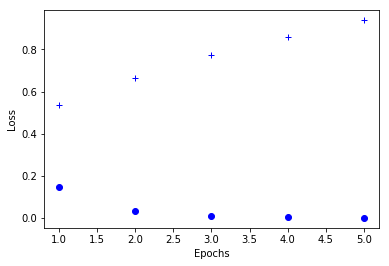

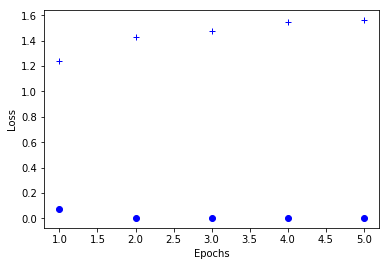

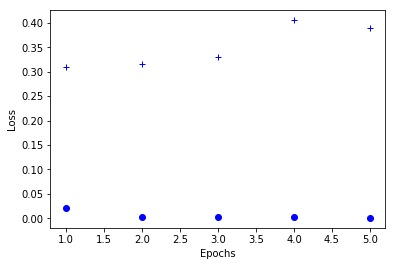

In [22]:
for model in models:
    history_dict = histories[model].history
    history_dict.keys()
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values) + 1)

    # "bo" is for "blue dot"
    plt.plot(epochs, loss_values, 'bo')
    # b+ is for "blue crosses"
    plt.plot(epochs, val_loss_values, 'b+')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()
    plt.clf()

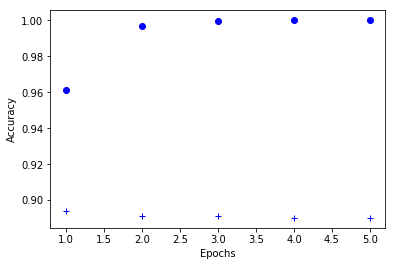

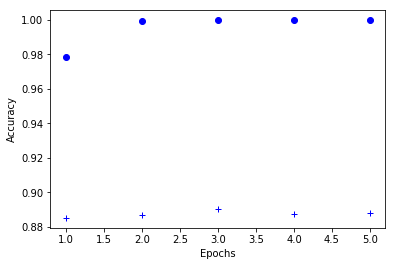

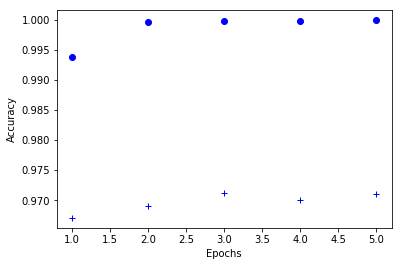

In [23]:
for model in models:
    history_dict = histories[model].history
    history_dict.keys()

    acc_values = history_dict['acc']
    val_acc_values = history_dict['val_acc']

    plt.plot(epochs, acc_values, 'bo')
    plt.plot(epochs, val_acc_values, 'b+')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.show()
    plt.clf()

In [24]:
for model in models:
    models[model].optimizer.lr=0.01
    gen = image.ImageDataGenerator()
    batches = gen.flow(X_train, y_train, batch_size=64)
    history = models[model].fit_generator(batches, batches.n, epochs=1)

Epoch 1/1
4000/4000 [==============================] - 13s 3ms/step - loss: 3.6720e-04 - acc: 1.0000: 4s - loss: 4.2817e-04 - ac - ETA: 3s  - ETA: 1s - loss: 
Epoch 1/1
4000/4000 [==============================] - 556s 139ms/step - loss: 0.0042 - acc: 0.9997
Epoch 1/1
4000/4000 [==============================] - 290s 73ms/step - loss: 1.0712e-04 - acc: 1.0000


In [26]:
predictions = models['tut'].predict_classes(X_test, verbose=0)

submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("prediction.csv", index=False, header=True)